# Collecting Metrics on Performance

The goal of this notebook is just to re-calculate the performance of our models trained on the augmented dataset
that included mirrored synthetic tornado examples. 

In this notebook, we'll calculate the AUC for each model we trained along the way (for all epochs of the augmented dataset
training) and we'll also calculate best critical success index (CSI) along with precision, recall, and F1-score for the
final model that did best.

In [1]:
import sys

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# just the location for the input data
TORNET_DATA_INPUT_FOLDER = "/mnt/c/users/handypark/Documents/Grad_School_Courses/CS_230/tornet"

2024-11-26 10:43:02.612553: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 10:43:02.795579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732646582.861361   26777 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732646582.880354   26777 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 10:43:03.026015: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Just making sure that we are indeed using GPU-based Tensorflow and not CPU-based Tensorflow.
tf.test.is_built_with_cuda()

# We tried experimental memory growth in some cases, but it didn't work out well (also crashed a lot).
"""
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
"""

'\ngpus = tf.config.list_physical_devices(\'GPU\')\nif gpus:\n  try:\n    # Currently, memory growth needs to be the same across GPUs\n    for gpu in gpus:\n      tf.config.experimental.set_memory_growth(gpu, True)\n    logical_gpus = tf.config.list_logical_devices(\'GPU\')\n    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")\n  except RuntimeError as e:\n    # Memory growth must be set before GPUs have been initialized\n    print(e)\n'

As usual, we include the helper functions from TorNet for building the model itself (so we can make predictions on the full test set and evaluate the resulting logits on how accurate they are).

In [3]:
"""
This is just the TorNet model code that was used in the paper.
Goal is to run this model which consists of:
- Normalizing the inputs
- Adding the coordinate information for CoordConv to work properly
- Running 4 VGG blocks which each have CoordConv2D and two MAXPOOL layers
- One last block of Conv2D layers and MAXPOOL to get the output probability
"""

from typing import Dict, List, Tuple
import numpy as np
import keras
from tornet.models.keras.layers import CoordConv2D, FillNaNs
from tornet.data.constants import CHANNEL_MIN_MAX, ALL_VARIABLES


def build_model(shape:Tuple[int]=(120,240,2),
                c_shape:Tuple[int]=(120,240,2),
                input_variables:List[str]=ALL_VARIABLES,
                start_filters:int=64,
                l2_reg:float=0.001,
                background_flag:float=-3.0,
                include_range_folded:bool=True,
                head='maxpool'):
    # Create input layers for each input_variables
    inputs = {}
    for v in input_variables:
        inputs[v]=keras.Input(shape,name=v)
    n_sweeps=shape[2]
    
    # Normalize inputs and concate along channel dim
    normalized_inputs=keras.layers.Concatenate(axis=-1,name='Concatenate1')(
        [normalize(inputs[v],v) for v in input_variables]
        )

    # Replace nan pixel with background flag
    normalized_inputs = FillNaNs(background_flag)(normalized_inputs)

    # Add channel for range folded gates 
    if include_range_folded:
        range_folded = keras.Input(shape[:2]+(n_sweeps,),name='range_folded_mask')
        inputs['range_folded_mask']=range_folded
        normalized_inputs = keras.layers.Concatenate(axis=-1,name='Concatenate2')(
               [normalized_inputs,range_folded])
        
    # Input coordinate information
    cin=keras.Input(c_shape,name='coordinates')
    inputs['coordinates']=cin

    x,c = normalized_inputs,cin
    
    x,c = vgg_block(x,c, filters=start_filters,   ksize=3, l2_reg=l2_reg, n_convs=2, drop_rate=0.1)   # (60,120)
    x,c = vgg_block(x,c, filters=2*start_filters, ksize=3, l2_reg=l2_reg, n_convs=2, drop_rate=0.1)  # (30,60)
    x,c = vgg_block(x,c, filters=4*start_filters, ksize=3, l2_reg=l2_reg, n_convs=3, drop_rate=0.1)  # (15,30)
    x,c = vgg_block(x,c, filters=8*start_filters, ksize=3, l2_reg=l2_reg, n_convs=3, drop_rate=0.1)  # (7,15)
    #x,c = vgg_block(x,c, filters=8*start_filters, ksize=3, l2_reg=l2_reg, n_convs=3)  # (3,7)
    
    if head=='mlp':
        # MLP head
        x = keras.layers.Flatten()(x) 
        x = keras.layers.Dense(units = 4096, activation ='relu')(x) 
        x = keras.layers.Dense(units = 2024, activation ='relu')(x) 
        output = keras.layers.Dense(1)(x)
    elif head=='maxpool':
        # Per gridcell
        x = keras.layers.Conv2D(filters=512, kernel_size=1,
                          kernel_regularizer=keras.regularizers.l2(l2_reg),
                          activation='relu')(x)
        x = keras.layers.Conv2D(filters=256, kernel_size=1,
                          kernel_regularizer=keras.regularizers.l2(l2_reg),
                          activation='relu')(x)
        x = keras.layers.Conv2D(filters=1, kernel_size=1,name='heatmap')(x)
        # Max in scene
        output = keras.layers.GlobalMaxPooling2D()(x)

    return keras.Model(inputs=inputs,outputs=output)


def vgg_block(x,c, filters=64, ksize=3, n_convs=2, l2_reg=1e-6, drop_rate=0.0):

    for _ in range(n_convs):
        x,c = CoordConv2D(filters=filters,
                          kernel_size=ksize,
                          kernel_regularizer=keras.regularizers.l2(l2_reg),
                          padding='same',
                          activation='relu')([x,c])
    x = keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    c = keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(c)
    if drop_rate>0:
        x = keras.layers.Dropout(rate=drop_rate)(x)
    return x,c


def normalize(x,
              name:str):
    """
    Channel-wise normalization using known CHANNEL_MIN_MAX
    """
    min_max = np.array(CHANNEL_MIN_MAX[name]) # [2,]
    n_sweeps=x.shape[-1]
    
    # choose mean,var to get approximate [-1,1] scaling
    var=((min_max[1]-min_max[0])/2)**2 # scalar
    var=np.array(n_sweeps*[var,])    # [n_sweeps,]
    
    offset=(min_max[0]+min_max[1])/2    # scalar
    offset=np.array(n_sweeps*[offset,]) # [n_sweeps,]

    return keras.layers.Normalization(mean=offset,
                                      variance=var,
                                      name='Normalize_%s' % name)(x)

In [4]:
model = build_model()
model.summary()

I0000 00:00:1732646591.220923   26777 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ DBZ (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VEL (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ KDP (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RHOHV (InputLayer)  │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ZDR (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ WIDTH (InputLayer)  │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalize_DBZ       │ (None, 120, 240,  │          0 │ DBZ[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalize_VEL       │ (None, 120, 240,  │          0 │ VEL[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalize_KDP       │ (None, 120, 240,  │          0 │ KDP[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalize_RHOHV     │ (None, 120, 240,  │          0 │ RHOHV[0][0]       │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalize_ZDR       │ (None, 120, 240,  │          0 │ ZDR[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalize_WIDTH     │ (None, 120, 240,  │          0 │ WIDTH[0][0]       │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate1        │ (None, 120, 240,  │          0 │ Normalize_DBZ[0]… │
│ (Concatenate)       │ 12)               │            │ Normalize_VEL[0]… │
│                     │                   │            │ Normalize_KDP[0]… │
│                     │                   │            │ Normalize_RHOHV[… │
│                     │                   │            │ Normalize_ZDR[0]… │
│                     │                   │            │ Normalize_WIDTH[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ isnan (Isnan)       │ (None, 120, 240,  │          0 │ Concatenate1[0][… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ where (Where)       │ (None, 120, 240,  │          0 │ isnan[0][0],      │
│                     │ 12)               │            │ Concatenate1[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 8,084,225 (30.84 MB)

 Trainable params: 8,084,225 (30.84 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Our own checkpoint creation / loading from checkpoint helper function
def checkpoint_creator(checkpoint_path):
    # saving the model's weights in case the iPython kernel crashes (which it likes to do)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_weights_only=True,
                                       verbose=1)
    return cp_callback

def checkpoint_loader(checkpoint_path, model):
    model.load_weights(checkpoint_path)

In [6]:
def preproc(ds: tf.data.Dataset,
            weights:Dict=None,
            include_az:bool=False,
            select_keys:list=None,
            tilt_last:bool=True):
    """
    This is Tornet's preprocessing function, unchanged,
    for taking the raw dataset loaded from the files (in create_tf_dataset)
    and then doing a few things:

    - Remove the time dimension (since we only care about detection at a given time t)
    - Add coordinates (so that we can run CoordConv layers later)
    - Split the data into its inputs and label outputs
    - Adding weights (if we decide to weight the data at all)

    Once the preprocessing is done, the data is basically ready to be trained on.
    """
    
    # Remove time dimension
    ds = ds.map(pp.remove_time_dim)

    # Add coordinate tensors
    ds = ds.map(lambda d: pp.add_coordinates(d,include_az=include_az,tilt_last=tilt_last,backend=tf))

    # split into X,y
    ds = ds.map(pp.split_x_y)

    # Add sample weights
    if weights:
        ds = ds.map(lambda x,y:  pp.compute_sample_weight(x,y,**weights, backend=tf) )
    
        # select keys for input
        if select_keys is not None:
            ds = ds.map(lambda x,y,w: (pp.select_keys(x,keys=select_keys),y,w))
    else:
        if select_keys is not None:
            ds = ds.map(lambda x,y: (pp.select_keys(x,keys=select_keys),y))

    return ds

def create_tf_dataset(files:str,
                      variables: List[str]=ALL_VARIABLES,
                      n_frames:int=1,
                      tilt_last: bool=True) -> tf.data.Dataset:
    """
    This is Tornet's main function for loading the data from the folder where it's all stored.
    
    As they stated, this creates a TF dataset object via the function read_file (which reads the NetCDF files
    into the data one at a time).
    """
    assert len(files)>0
    # grab one file to gets keys, shapes, etc
    data = read_file(files[0],variables=variables,n_frames=n_frames, tilt_last=tilt_last)
    
    output_signature = { k:tf.TensorSpec(shape=data[k].shape,dtype=data[k].dtype,name=k) for k in data }
    def gen():
        for f in files:
            yield read_file(f,variables=variables,n_frames=n_frames, tilt_last=tilt_last)
    ds = tf.data.Dataset.from_generator(gen,
                                        output_signature=output_signature)
    return ds

def make_tf_loader(data_root: str, 
            data_type:str='train', # or 'test'
            years: list=list(range(2013,2023)),
            batch_size: int=128, 
            weights: Dict=None,
            include_az: bool=False,
            random_state:int=1234,
            select_keys: list=None,
            tilt_last: bool=True,
            from_tfds: bool=False,
            tfds_data_version: str='1.1.0',
            num_epochs: int=3):
    """
    This TorNet library function is used to load the data into Tensorflow.
    We're going to use the `create_tf_dataset` function from above, 
    then we'll use `preproc` to preprocess it.

    One important note - we tried a bunch of different functions for shuffling 
    and batching, repeating the dataset, etc. to try to be able to run
    many epochs with one function call. It wasn't working.
    Even the `drop_remainder=True` that we've added here to ds.batch
    seems to not really have an effect, as the model training
    still throws an error at the end of training about running out of data.
    """
    
    if from_tfds: # fast loader
        import tensorflow_datasets as tfds
        import tornet.data.tfds.tornet.tornet_dataset_builder # registers 'tornet'
        ds = tfds.load('tornet:%s' % tfds_data_version ,split='+'.join(['%s-%d' % (data_type,y) for y in years]))
        # Assumes data was saved with tilt_last=True and converts it to tilt_last=False
        if not tilt_last:
            ds = ds.map(lambda d: pp.permute_dims(d,(0,3,1,2), backend=tf))
    else: # Load directly from netcdf files
        file_list = query_catalog(data_root, data_type, years, random_state)
        ds = create_tf_dataset(file_list,variables=ALL_VARIABLES,n_frames=1, tilt_last=tilt_last) 

    ds = preproc(ds,weights,include_az,select_keys,tilt_last)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    # this has been adjusted to include drop_remainder=True
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds

## Testing for our final model

Let's get the predictions from our final model and calculate the metrics.

We load the entirety of the test dataset, run the newly trained model on the full set, and calculate metrics using the logits that we generated from the results. (Note that the raw results of this CNN are in logit form rather than probabilities - we'll have to keep that in mind for later.)

In [7]:
from typing import List, Dict

from tornet.data.loader import query_catalog, read_file
from tornet.data.constants import ALL_VARIABLES
from tornet.data import preprocess as pp
import numpy as np

checkpoint_loader("checkpoints/epoch_flipping_12_1e-5.weights.h5", model)
loss = keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [keras.metrics.AUC(from_logits=True,name='AUC')]
model.compile(loss=loss, metrics=metrics)

test_data = make_tf_loader(data_root = TORNET_DATA_INPUT_FOLDER, 
                              data_type = "test",
                              years = list(range(2013, 2023)),
                              batch_size = 64, 
                              weights = None,
                              include_az = False,
                              random_state = 5678,
                              select_keys = ALL_VARIABLES + ["coordinates", "range_folded_mask"],
                              tilt_last = True,
                              from_tfds = False,
                              tfds_data_version ="1.1.0")

scores = model.predict(test_data) 


I0000 00:00:1732582404.950675   14705 service.cc:148] XLA service 0x7fbea0003440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732582404.950950   14705 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-11-25 16:53:24.980416: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732582405.053503   14705 cuda_dnn.cc:529] Loaded cuDNN version 90300


      2/Unknown 12s 88ms/step

I0000 00:00:1732582412.310828   14705 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 ━━━━━━━━━━━━━━━━━━━━ 1697s 3s/step


2024-11-25 17:21:38.344369: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Now we'll just grab all the actual labels from the test dataset so we have the ground truth to compare against.

In [21]:
counter = 0
arr = np.zeros((len(scores),1))
index = 0
for data_x, labels_y in test_data:
    if counter % 5 == 0:
        print(index)
    labels_y_list = labels_y.numpy().tolist()
    for i, y in enumerate(labels_y_list):
        arr[index + i] = y
    index += 64
    counter += 1

0
320
640
960
1280
1600
1920
2240
2560
2880
3200
3520
3840
4160
4480
4800
5120
5440
5760
6080
6400
6720
7040
7360
7680
8000
8320
8640
8960
9280
9600
9920
10240
10560
10880
11200
11520
11840
12160
12480
12800
13120
13440
13760
14080
14400
14720
15040
15360
15680
16000
16320
16640
16960
17280
17600
17920
18240
18560
18880
19200
19520
19840
20160
20480
20800
21120
21440
21760
22080
22400
22720
23040
23360
23680
24000
24320
24640
24960
25280
25600
25920
26240
26560
26880
27200
27520
27840
28160
28480
28800
29120
29440
29760
30080
30400
30720
31040
31360


In [22]:
len(scores)

31424

We save our predicted logits and actual labels just in case we have a kernel crash at any point in the notebook.

In [23]:
"""
import numpy as np
import pickle

with open('scores_predicted.pkl', 'wb') as f:
    pickle.dump(scores, f)

with open('actual_labels.npy', 'wb') as f:
    np.save(f, arr)
"""

In [34]:
import numpy as np
import pickle
with open('scores_predicted.pkl', 'rb') as f:
    scores = pickle.load(f)

with open('actual_labels.npy', 'rb') as f:
    actuals = np.load(f)

# Metrics for the fully-trained model (after 12 epochs)

Let's go ahead and plot the ROC curve first and grab the AUC.

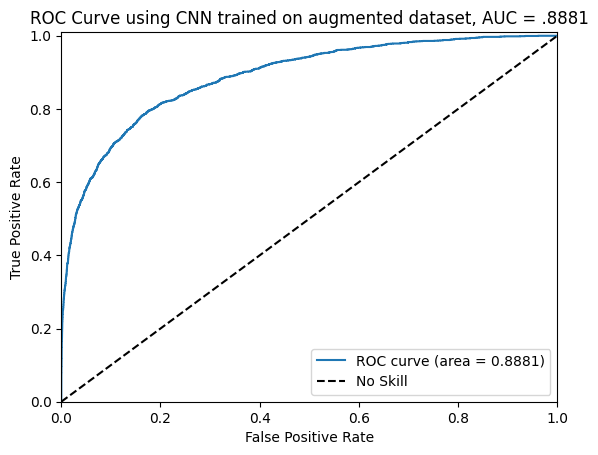

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

actuals = actuals.tolist()
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(actuals, scores) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve using CNN trained on augmented dataset, AUC = .8881')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

This is a significant result. Recall that the original model had an AUC of .8742, with a standard deviation of .0062.
We've beaten that original result by more than two standard deviations using the augmentation strategy to add in many synthetic flipped tornadoes; this AUC achieved is .8881 - compared to the TorNet paper's validation AUC on the full test dataset. 

When running a one-sided probability test on this result, we'd find that the chance of seeing an AUC this high if the performance of the model was only equal to the original model is quite low - given an achieved/observed validation AUC of .8881, the original benchmark of .8742, and the original standard deviation in AUC's of .0062, the probability of seeing an AUC this high or higher (given equal performance rather than better performance) is 1.24% (with a Z-score of 2.242). Since that is below 5%, that is a significant result (especially given that we achieved this result on our first model trained with the new, augmented dataset) - meaning that it's highly probable that the augmented dataset gives us a better result.

How did we do on accuracy, precision, recall, F1-score, and the critical success index (CSI)? [Note that CSI is defined as the ratio of true positives to the sum of true positives, false positives, and false negatives.]

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
    
"""
Calculating the best logits decision threshold to use for critical success index + F1 score.
Note that the TorNet authors also searched for the best threshold to use
for these statistics when publishing their statistics for CSI and accuracy.
"""
bests = {}
bests["accuracy"] = (-1000, 0)
bests["precision"] = (-1000, 0)
bests["recall"] = (-1000, 0)
bests["f1_score"] = (-1000, 0)
bests["csi"] = (-1000, 0)
print(max(scores), min(scores))

for threshold in range(-60, 80, 1):
    floated = threshold * 0.1
    predictions = [1 if x > floated else 0 for x in scores]
    labels = [(int)(x[0]) for x in actuals]
    current = {}
    current["accuracy"] = accuracy_score(labels, predictions)
    current["precision"] = precision_score(labels, predictions)
    current["recall"] = recall_score(labels, predictions)
    current["f1_score"] = f1_score(labels, predictions)
    c_mat = confusion_matrix(labels, predictions)
    true_positives = 1.0 * c_mat[1][1]
    denominator = c_mat[0][1] + c_mat[1][0] + c_mat[1][1]
    current["csi"] = true_positives / denominator # CSI is defined as true positives / (true positives + false positives + false negatives)
    for stat in current.keys():
        if current[stat] > bests[stat][1]:
            bests[stat] = (floated, current[stat])

    

[7.9153523] [-6.0892115]


In [45]:
print(bests)

{'accuracy': (0.7000000000000001, 0.9498154276985743), 'precision': (4.800000000000001, 1.0), 'recall': (-6.0, 1.0), 'f1_score': (-0.9, 0.5235414534288638), 'csi': (-0.9, 0.35459272097053723)}


In [46]:
floated = -.9
predictions = [1 if x > floated else 0 for x in scores]
labels = [(int)(x[0]) for x in actuals]
current = {}
current["accuracy"] = accuracy_score(labels, predictions)
current["precision"] = precision_score(labels, predictions)
current["recall"] = recall_score(labels, predictions)
current["f1_score"] = f1_score(labels, predictions)
c_mat = confusion_matrix(labels, predictions)
true_positives = 1.0 * c_mat[1][1]
denominator = c_mat[0][1] + c_mat[1][0] + c_mat[1][1]
current["csi"] = true_positives / denominator # CSI is defined as true positives / (true positives + false positives + false negatives)
print(current)

{'accuracy': 0.9407459266802444, 'precision': 0.5325351379489849, 'recall': 0.5148465022647207, 'f1_score': 0.5235414534288638, 'csi': 0.35459272097053723}


Of note here, CSI is also significantly improved from the original TorNet paper.

Our model’s CSI of .3546 is a strong improvement over TorNet’s original model CSI of .3380 with a
standard deviation of σ = .0063. With a Z-score of 2.635, the chance of observing a CSI this high
given only equal performance would be merely 0.42% - again a stastically significant improvement.

This is especially meaningful given that CSI hopes to maximize the number of true positives compared to all positive predictions and false negatives. It also makes sense that our model did better on this front - with more tornadic examples, we may have a few more false positives, but given the class imbalance we were seeing before, the added examples provide enough usefulness for us to reduce the number of false negatives more than enough to offset any additional false positives we might have.

## Plotting performance by epoch

Now we want to get some sense of how the models did as we trained more and more epochs of mini-batch gradient descent.

A lot of this data is taken from the previous notebook where we did the actual training, and is being plotted here.

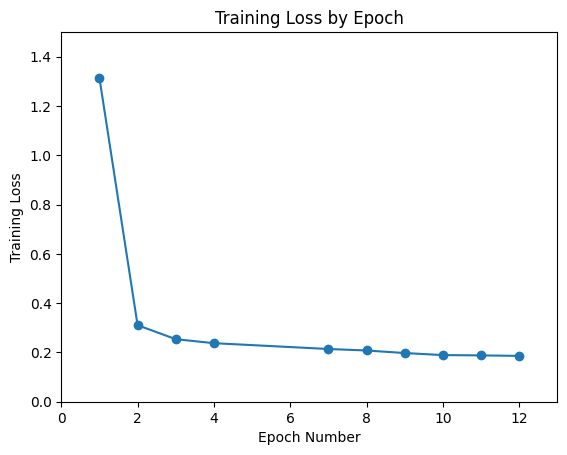

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

x_epochs = [1, 2, 3, 4, 7, 8, 9, 10, 11, 12]
y_losses = [1.3143, 0.3107, 0.2538, 0.2376, 0.2140, 0.2079, 0.1976, 0.1893, 0.1880, 0.1860]

plt.figure()  
plt.plot(x_epochs, y_losses, '-o')
plt.xlim([0.0, 13.0])
plt.ylim([0.0, 1.5])
plt.xlabel('Epoch Number')
plt.ylabel('Training Loss')
plt.title('Training Loss by Epoch')
plt.savefig('training_loss_by_epoch.png')
plt.show()

/tmp/ipykernel_17127/774459943.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


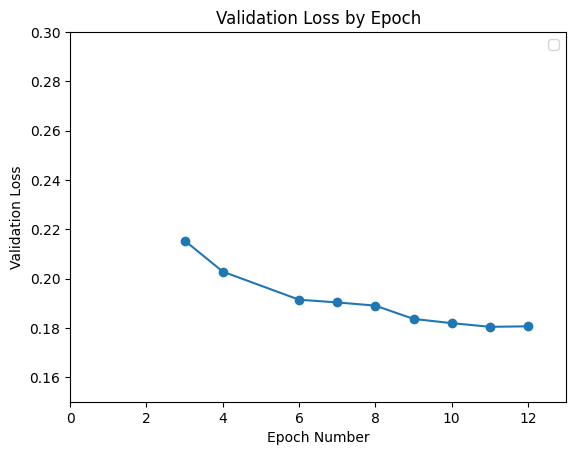

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

x_epochs = [3, 4, 6, 7, 8, 9, 10, 11, 12]
y_AUC = [0.8184, 0.8388, 0.8609, 0.8659, 0.8663, 0.8804, 0.8821, 0.8846, 0.8854]
y_losses = [0.2154, 0.2028, 0.1914, 0.1903, 0.1890, 0.1836, 0.1819, 0.1804, 0.1806]

plt.figure()  
plt.plot(x_epochs, y_losses, '-o')
plt.xlim([0.0, 13.0])
plt.ylim([0.15, 0.3])
plt.xlabel('Epoch Number')
plt.ylabel('Validation Loss')
plt.title('Validation Loss by Epoch')
plt.legend()
plt.savefig('validation_loss_by_epoch.png')
plt.show()

We also want to calculate just how well each individual model did along the way (by calculating predictions on the test set after each epoch and then plotting the AUC by epoch).

I0000 00:00:1732591364.501536   17227 service.cc:148] XLA service 0x7fee8801b350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732591364.502270   17227 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-11-25 19:22:44.569877: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732591364.773699   17227 cuda_dnn.cc:529] Loaded cuDNN version 90300


      2/Unknown 16s 93ms/step

I0000 00:00:1732591372.714902   17227 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 ━━━━━━━━━━━━━━━━━━━━ 1942s 4s/step


2024-11-25 19:54:59.243661: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


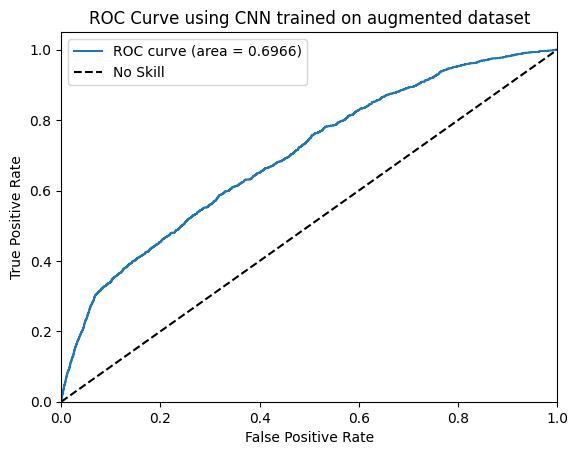

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


491/491 ━━━━━━━━━━━━━━━━━━━━ 1596s 3s/step


2024-11-25 20:21:36.327088: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


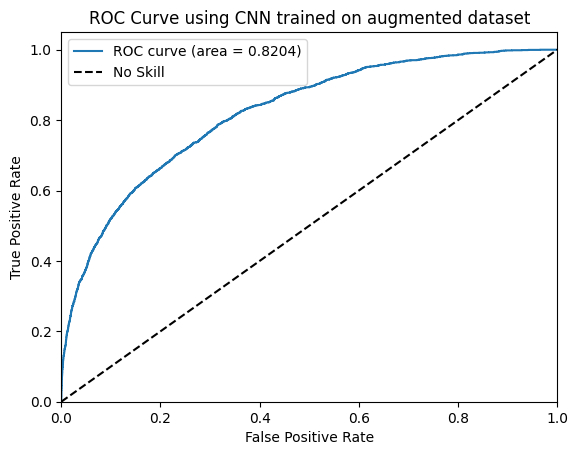

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-11-25 20:21:40.061609: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 117964864 bytes after encountering the first element of size 117964864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


491/491 ━━━━━━━━━━━━━━━━━━━━ 1618s 3s/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


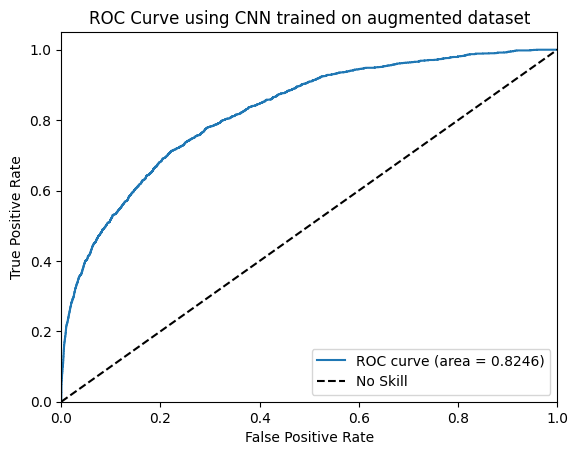

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-11-25 20:48:38.451119: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 117964864 bytes after encountering the first element of size 117964864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


491/491 ━━━━━━━━━━━━━━━━━━━━ 1584s 3s/step


2024-11-25 21:14:58.392179: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


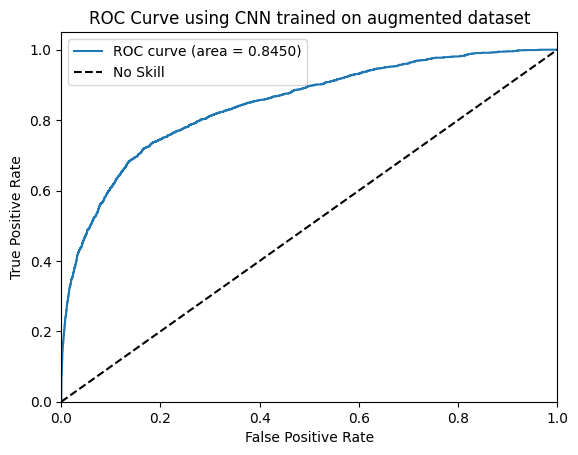

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-11-25 21:15:02.616013: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 117964864 bytes after encountering the first element of size 117964864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


491/491 ━━━━━━━━━━━━━━━━━━━━ 1569s 3s/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


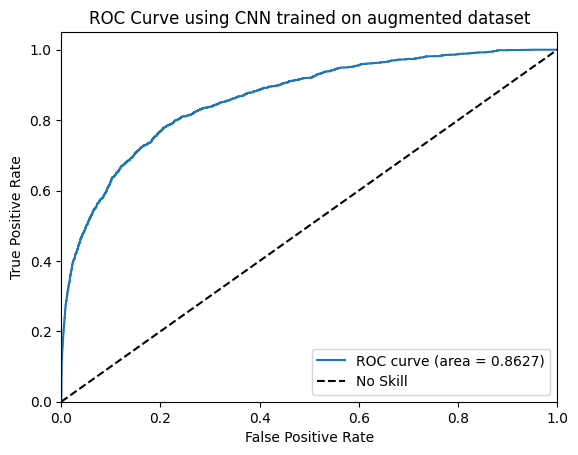

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-11-25 21:41:11.106853: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 117964864 bytes after encountering the first element of size 117964864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


491/491 ━━━━━━━━━━━━━━━━━━━━ 1551s 3s/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


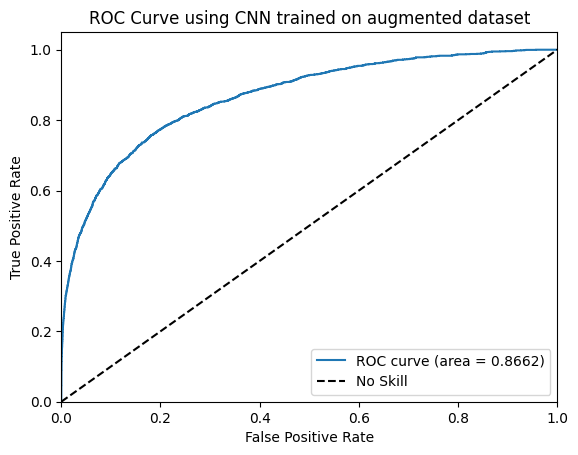

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


491/491 ━━━━━━━━━━━━━━━━━━━━ 1591s 3s/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


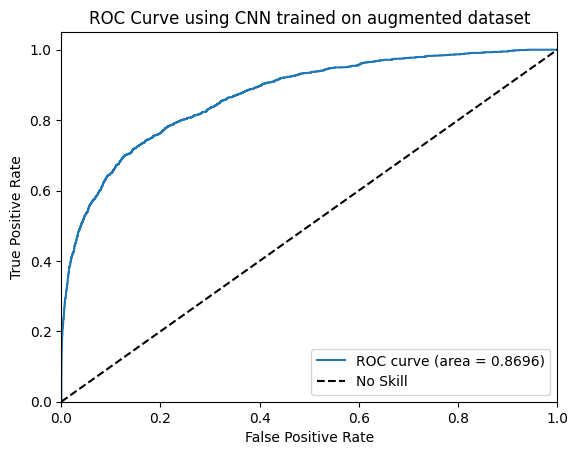

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-11-25 22:33:33.675861: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 117964864 bytes after encountering the first element of size 117964864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


491/491 ━━━━━━━━━━━━━━━━━━━━ 1877s 4s/step


2024-11-25 23:04:47.185540: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


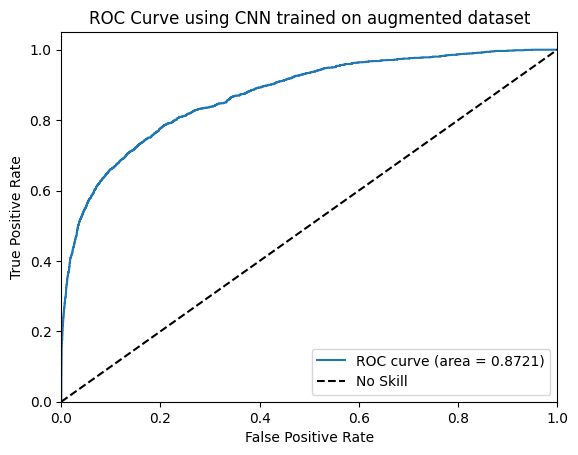

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-11-25 23:04:53.083002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 117964864 bytes after encountering the first element of size 117964864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


491/491 ━━━━━━━━━━━━━━━━━━━━ 2223s 5s/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


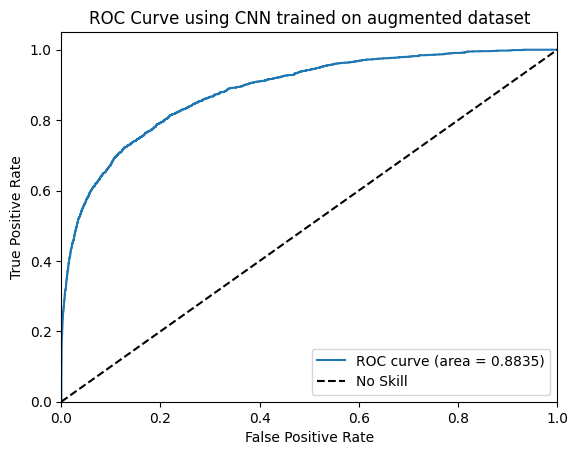

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-11-25 23:41:57.951906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 117964864 bytes after encountering the first element of size 117964864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


491/491 ━━━━━━━━━━━━━━━━━━━━ 2142s 4s/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


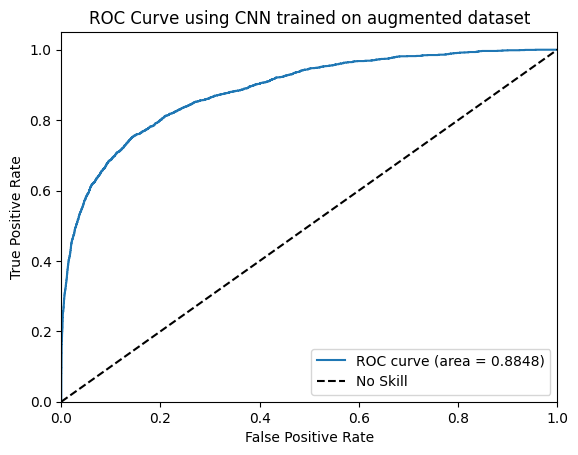

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


491/491 ━━━━━━━━━━━━━━━━━━━━ 1629s 3s/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


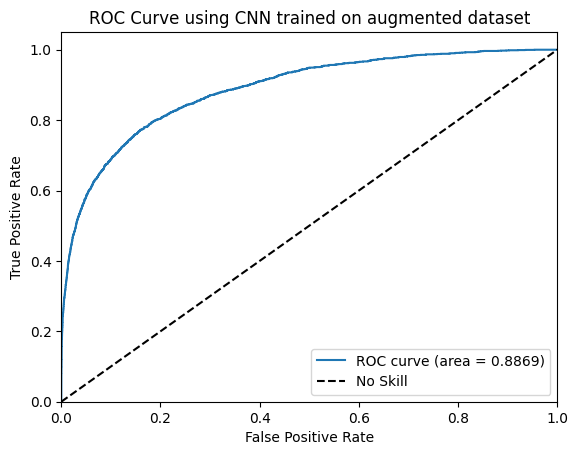

/usr/local/lib/python3.9/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-11-26 00:44:48.697472: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 117964864 bytes after encountering the first element of size 117964864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


491/491 ━━━━━━━━━━━━━━━━━━━━ 1643s 3s/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


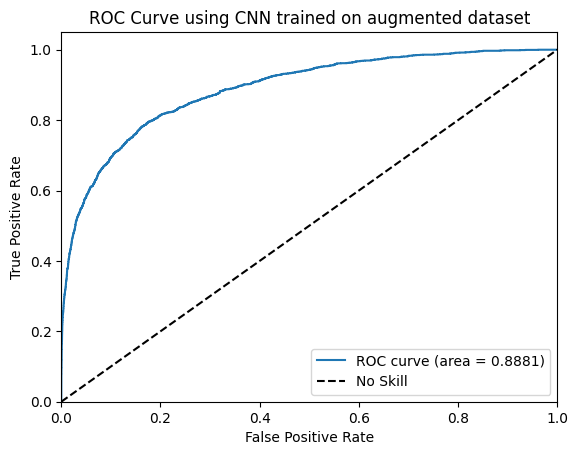

In [51]:
from typing import List, Dict

from tornet.data.loader import query_catalog, read_file
from tornet.data.constants import ALL_VARIABLES
from tornet.data import preprocess as pp

from sklearn.metrics import roc_curve, auc
import numpy as np
import pickle
import matplotlib.pyplot as plt

test_data = make_tf_loader(data_root = TORNET_DATA_INPUT_FOLDER, 
                              data_type = "test",
                              years = list(range(2013, 2023)),
                              batch_size = 64, 
                              weights = None,
                              include_az = False,
                              random_state = 5678,
                              select_keys = ALL_VARIABLES + ["coordinates", "range_folded_mask"],
                              tilt_last = True,
                              from_tfds = False,
                              tfds_data_version ="1.1.0")

with open('actual_labels.npy', 'rb') as f:
    actuals = np.load(f)

for i in range(1, 13):
    if i <= 9:
        checkpoint_loader("checkpoints/epoch_flipping_{}_1e-4.weights.h5".format(i), model)
    else:
        checkpoint_loader("checkpoints/epoch_flipping_{}_1e-5.weights.h5".format(i), model)
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(loss=loss)
    scores_for_epoch = model.predict(test_data) 
    with open('scores_predicted_{}.pkl'.format(i), 'wb') as f:
        pickle.dump(scores_for_epoch, f)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(actuals.tolist(), scores_for_epoch) 
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()  
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve using CNN trained on augmented dataset')
    plt.legend()
    plt.savefig('roc_curve_{}.png'.format(i))
    plt.show()

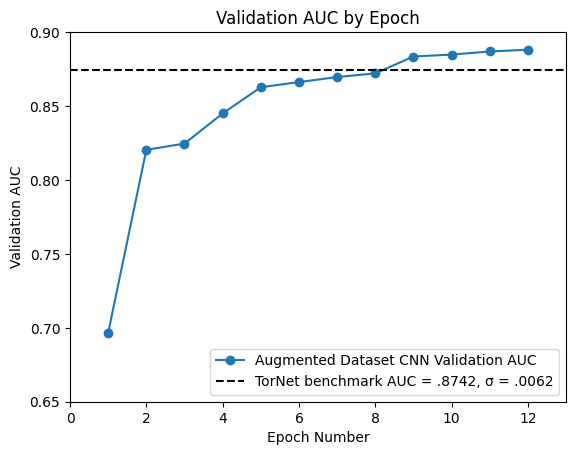

In [60]:
from sklearn.metrics import roc_curve, auc

x_epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
y_AUC = [0.6966, 0.8204, 0.8246, 0.8450, 0.8627, 0.8662, 0.8696, 0.8721, 0.8835, 0.8848, 0.8869, 0.8881]

plt.figure()  
plt.plot(x_epochs, y_AUC, '-o', label="Augmented Dataset CNN Validation AUC")
plt.plot([0, 13.0], [.8742, .8742], 'k--', label="TorNet benchmark AUC = .8742, \u03C3 = .0062")
plt.xlim([0.0, 13.0])
plt.ylim([0.65, 0.9])
plt.xlabel('Epoch Number')
plt.ylabel('Validation AUC')
plt.title('Validation AUC by Epoch')
plt.legend(loc="lower right")
plt.savefig('validation_AUC_by_epoch.png')
plt.show()

Of particular note: it's not just one model that beats the original - multiple of the later epochs perform better than the original by a significant amount due to the help of the additional synthetic tornado examples.

# Conclusion

- Flipping the tornadoes to create augmented data did NOT adversely impact the model that was trained. This was a concern that we had initially (is there weird "directionality" or "spin direction" that is lost when we flip the tornado?) but it proved to not be the case, and we achieved great success here.
    - We improved both AUC and CSI significantly in the best model that we trained after 12 epochs.
    - We also improved AUC in every model after the 8th epoch!
- In fact, flipping the tornado images to create augmented data (as mentioned above) is probably a great strategy to 'create' more tornadoes and help correct for class imbalance caused by a relative lack of tornado data.
    - The end result of such flipping seems to be that we increase the number of true positives by decreasing the number of false negative predictions (we predict more tornadoes while not doing so indiscriminately - this is how we were able to boost CSI, which measured the ratio of true positives to all positives and false negatives). 
- In addition, what this shows above all is that CNN models trained on the dataset could do even better if we collect more tornado examples. Future research should not only use mirroring to augment the dataset, but should also focus on expanding the dataset to include more examples of labeled tornadoes.
    - If anything, while the success of this solution shows that flipping some data is a good stopgap measure given a lack of data, it also proves that just generally having more tornado examples would absolutely help boost performance (because our synthetic tornadoes are essentially nothing more than just additional examples of tornadoes that help correct class imbalance).
